<a href="https://colab.research.google.com/github/BaikaiL/voice/blob/main/voice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai-whisper==20250625 --no-deps

In [ ]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)


True
12.6


In [ ]:
import whisper
model = whisper.load_model("small").to("cuda")
print("Whisper small loaded!")

Whisper small loaded!


In [ ]:
result1 = model.transcribe("common_voice_zh-HK_20099797.wav", fp16=False)
print(result1["text"])
result2 = model.transcribe("common_voice_zh-HK_20101461.wav", fp16=False)
print(result2["text"])
result3 = model.transcribe("common_voice_zh-HK_20101462.wav", fp16=False)
print(result3["text"])
result4 = model.transcribe("common_voice_zh-HK_20101463.wav", fp16=False)
print(result4["text"])

In [ ]:
!pip install modelscope


In [ ]:
!pip install addict

In [ ]:
!git clone https://www.modelscope.cn/datasets/tomsawyerhu/cantonese-dialect.git

fatal: destination path 'cantonese-dialect' already exists and is not an empty directory.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="train.csv")["train"]

# ⭐ 新增：去除 Text 中所有空格（包括中英文空格）
def clean_text(batch):
    if "Text" in batch and isinstance(batch["Text"], str):
        batch["Text"] = batch["Text"].replace(" ", "")
    return batch

dataset = dataset.map(clean_text)

dataset[0]


{'Audio': 'https://dataset-hub.oss-cn-hangzhou.aliyuncs.com/public-unzipped/tomsawyerhu_cantonese-dialect_cantonese_dialect_small/cantonese_dialect_small/common_voice_zh-HK_22262988.wav?Expires=1763882317&OSSAccessKeyId=LTAI5tAoCEDFQFyV5h8unjt8&Signature=TC73%2FQfFxeEO%2FETQyTanGyunwvk%3D',
 'Text': '有个老人去左坪洲永安横街食斋'}

In [ ]:
import os
import requests

os.makedirs("audio_cache", exist_ok=True)

def download_audio(batch):
    url = batch["Audio"]
    filename = url.split("/")[-1].split("?")[0]  # 去掉URL参数
    path = f"audio_cache/{filename}"

    if not os.path.exists(path):
        with open(path, "wb") as f:
            f.write(requests.get(url).content)

    batch["audio_path"] = path
    return batch

dataset = dataset.map(download_audio)


In [ ]:
dataset[0]

{'Audio': 'https://dataset-hub.oss-cn-hangzhou.aliyuncs.com/public-unzipped/tomsawyerhu_cantonese-dialect_cantonese_dialect_small/cantonese_dialect_small/common_voice_zh-HK_22262988.wav?Expires=1763882317&OSSAccessKeyId=LTAI5tAoCEDFQFyV5h8unjt8&Signature=TC73%2FQfFxeEO%2FETQyTanGyunwvk%3D',
 'Text': '有个老人去左坪洲永安横街食斋',
 'audio_path': 'audio_cache/common_voice_zh-HK_22262988.wav'}

In [ ]:
import os

file_path = "audio_cache/common_voice_zh-HK_22112024.wav"

if os.path.exists(file_path):
    size = os.path.getsize(file_path)
    print(f"文件存在，大小为: {size} bytes")
    if size < 100:
        print("⚠️ 文件太小，可能已损坏或为空文件！")
else:
    print("❌ 文件根本不存在，请检查路径或下载过程。")

文件存在，大小为: 532302 bytes


In [ ]:
import librosa

def load_and_resample(batch):
    speech, sr = librosa.load(batch["audio_path"], sr=16000)
    batch["speech"] = speech
    batch["sampling_rate"] = 16000
    return batch

dataset = dataset.map(load_and_resample)


Map:   0%|          | 0/99 [00:00<?, ? examples/s]

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="yue", task="transcribe")

def prepare_features(batch):
    inputs = processor(
        batch["speech"],
        sampling_rate=16000,
        text=batch["Text"]
    )
    batch["input_features"] = inputs["input_features"][0]
    batch["labels"] = inputs["labels"]
    return batch

dataset = dataset.map(prepare_features, remove_columns=dataset.column_names)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/99 [00:00<?, ? examples/s]

In [ ]:
import torch

class WhisperDataCollator:
    def __init__(self, processor):
        self.processor = processor

    def __call__(self, batch):
        # 1. 处理输入特征 (mel spectrogram)
        input_features = [item["input_features"] for item in batch]
        batch_inputs = self.processor.feature_extractor.pad(
            {"input_features": input_features},
            return_tensors="pt"
        )

        # 2. 处理标签
        labels = [item["labels"] for item in batch]
        batch_labels = self.processor.tokenizer.pad(
            {"input_ids": labels},
            padding=True,
            return_tensors="pt"
        )["input_ids"]

        # Whisper 要把 padding 部分改成 -100
        batch_labels[batch_labels == self.processor.tokenizer.pad_token_id] = -100

        batch_inputs["labels"] = batch_labels
        return batch_inputs


In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from transformers import TrainingArguments, Trainer

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="yue", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")

data_collator = WhisperDataCollator(processor)


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
username = "baikai1022"
repo_name = "whisper-small-cantonese-v2"
hub_model_id = f"{username}/{repo_name}"

training_args = TrainingArguments(
    output_dir="./whisper-small-cantonese",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    fp16=True,
    learning_rate=1e-5,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_steps=20,
    push_to_hub=True,               # 【关键】训练结束自动上传
    hub_model_id=hub_model_id,      # 指定上传的仓库ID
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=processor.feature_extractor,
    data_collator=data_collator   # ⭐ 使用自定义 Collator
)

trainer.train()
trainer.push_to_hub()

trainer.save_model("./whisper-small-cantonese")
processor.save_pretrained("./whisper-small-cantonese")


/tmp/ipython-input-645295009.py:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
20,1.917600


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ntonese/training_args.bin: 100%|##########| 5.91kB / 5.91kB            

  ...3962.195dc553c6aa.10501.1: 100%|##########| 6.33kB / 6.33kB            

  ...3580.195dc553c6aa.10501.0: 100%|##########| 6.65kB / 6.65kB            

  ...ntonese/model.safetensors:   3%|3         | 33.5MB /  967MB            

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...ntonese/training_args.bin: 100%|##########| 5.91kB / 5.91kB            

  ...3580.195dc553c6aa.10501.0: 100%|##########| 6.65kB / 6.65kB            

  ...3962.195dc553c6aa.10501.1: 100%|##########| 6.33kB / 6.33kB            

  ...ntonese/model.safetensors:   3%|3         | 33.5MB /  967MB            

No files have been modified since last commit. Skipping to prevent empty commit.


[]

In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 118.3 MB/s eta 0:00:00


In [ ]:
import csv
import os

test_dir = "test"
csv_path = os.path.join(test_dir, "test.csv")

audio_files = []
labels = []

with open(csv_path, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        filename = row["Audio:FILE"].strip()
        text = row["Text:LABEL"].strip().replace(" ", "")
        audio_files.append(os.path.join(test_dir, filename))
        labels.append(text)
print(len(audio_files), "samples loaded")
print(audio_files[0], labels[0])


13 samples loaded
test/common_voice_zh-HK_20110217.wav 有个老婆婆喺大埔滘翠峦路等紧小巴


In [ ]:
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import torch
import librosa

device = "cuda"

# 原始模型（微调前）
processor_base = WhisperProcessor.from_pretrained("openai/whisper-small")
model_base = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

# 微调后的模型
processor_ft = WhisperProcessor.from_pretrained("./whisper-small-cantonese")
model_ft = WhisperForConditionalGeneration.from_pretrained("./whisper-small-cantonese").to(device)


In [ ]:
def transcribe(model, processor, audio_path):
    audio, sr = librosa.load(audio_path, sr=16000)
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt").to(device)
    with torch.no_grad():
        ids = model.generate(inputs.input_features)
    return processor.batch_decode(ids, skip_special_tokens=True)[0]


In [ ]:
pred_base = []
pred_ft = []

for wav in audio_files:
    pred_base.append(transcribe(model_base, processor_base, wav))
    pred_ft.append(transcribe(model_ft, processor_ft, wav))


Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
`generation_config` default values have been modified to match model-specific defaults: {'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982,

In [ ]:
!pip install jiwer

In [ ]:
from jiwer import wer, cer

print("---- BEFORE FINETUNE ----")
print("WER:", wer(labels, pred_base))
print("CER:", cer(labels, pred_base))

print("\n---- AFTER FINETUNE ----")
print("WER:", wer(labels, pred_ft))
print("CER:", cer(labels, pred_ft))


---- BEFORE FINETUNE ----
WER: 1.1538461538461537
CER: 0.5615763546798029

---- AFTER FINETUNE ----
WER: 1.0
CER: 0.3448275862068966


In [ ]:
for i in range(len(audio_files)):
    print(f"[{i}] {audio_files[i]}")
    print("   Label     :", labels[i])
    print("   Before FT :", pred_base[i])
    print("   After  FT :", pred_ft[i])
    print("-"*80)


[0] test/common_voice_zh-HK_20110217.wav
   Label     : 有个老婆婆喺大埔滘翠峦路等紧小巴
   Before FT : 有個老婆婆在大埔教翠聯路等小巴
   After  FT : 有个老婆婆喺大埔教翠链路等緊小巴
--------------------------------------------------------------------------------
[1] test/common_voice_zh-HK_20110241.wav
   Label     : 比我一个人静下得唔得
   Before FT : 給我一個人靜一下行不行
   After  FT : 比我一个人靜下得唔得
--------------------------------------------------------------------------------
[2] test/common_voice_zh-HK_20136999.wav
   Label     : 流浪猫喺沙田禾盛街嘅垃圾桶揾野食
   Before FT : 流浪貓在沙田和盛街的垃圾桶找食物
   After  FT : 流浪猫喺沙田河盛街嘅垃圾桶吻饿饿食。
--------------------------------------------------------------------------------
[3] test/common_voice_zh-HK_20137330.wav
   Label     : 回本首选的冻海鲜
   Before FT : 回本首選的凍海鮮
   After  FT : 回本首选的洞海鲜
--------------------------------------------------------------------------------
[4] test/common_voice_zh-HK_20137412.wav
   Label     : 因母亲去世要养家，要悭钱喺公司煮饭
   Before FT : 因母親去世要養家,要省錢在公司煮飯
   After  FT : 因母亲去世要养家要省钱喺公司煮饭
-----------------------------

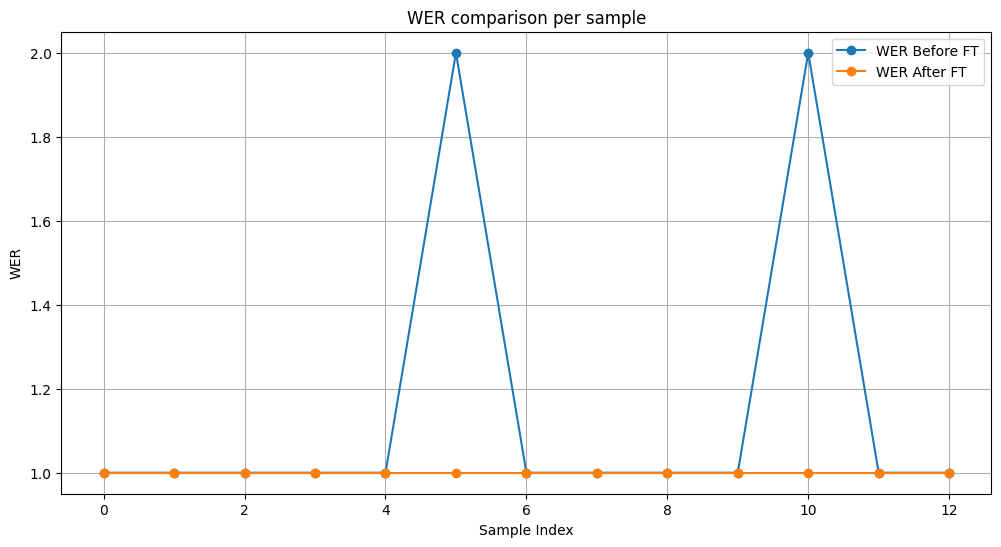

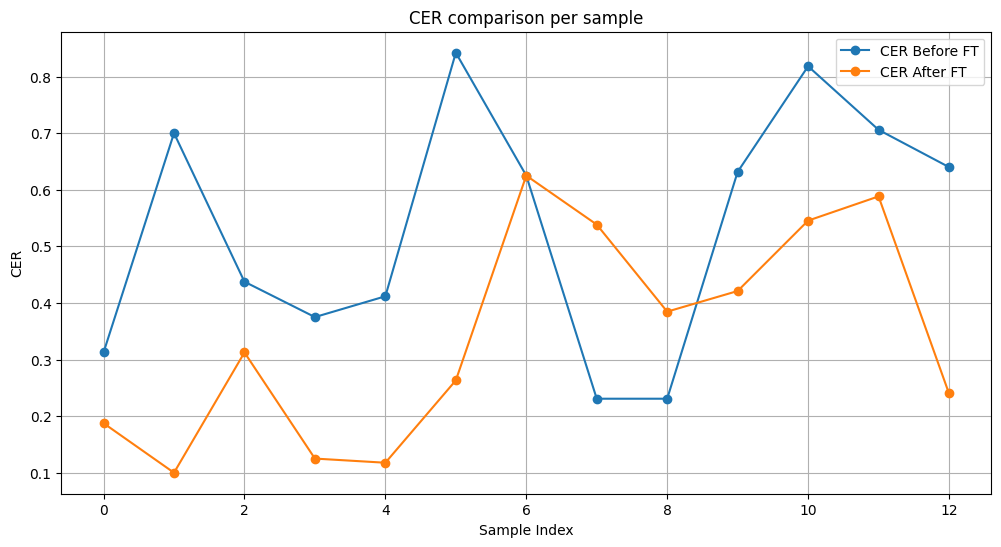

In [ ]:
import matplotlib.pyplot as plt
from jiwer import wer, cer

wer_base_list = []
wer_ft_list = []
cer_base_list = []
cer_ft_list = []

for ref, b, f in zip(labels, pred_base, pred_ft):
    wer_base_list.append(wer([ref], [b]))
    wer_ft_list.append(wer([ref], [f]))
    cer_base_list.append(cer([ref], [b]))
    cer_ft_list.append(cer([ref], [f]))

plt.figure(figsize=(12,6))
plt.plot(wer_base_list, label="WER Before FT", marker="o")
plt.plot(wer_ft_list, label="WER After FT", marker="o")
plt.title("WER comparison per sample")
plt.xlabel("Sample Index")
plt.ylabel("WER")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(cer_base_list, label="CER Before FT", marker="o")
plt.plot(cer_ft_list, label="CER After FT", marker="o")
plt.title("CER comparison per sample")
plt.xlabel("Sample Index")
plt.ylabel("CER")
plt.legend()
plt.grid()
plt.show()


mt机器翻译模型实现

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 小型、支持粤语的翻译模型
model_name = "facebook/nllb-200-distilled-600M"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to("cuda")

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
# Whisper 识别到的文本（粤语/繁体）
text = "佢哋即使唔系亲生兄弟，感情都好似手足咁好。"
print(text)
# ★ 你的 tokenizer 中的有效语言代码：
src_lang = "yue_Hant"     # 粤语（繁体）
tgt_lang = "zho_Hans"     # 中文（简体）

# ★ 在输入文本前加入语言 token（不加尖括号！）
src_prefixed = src_lang + " " + text

inputs = tokenizer(
    src_prefixed,
    return_tensors="pt",
    padding=True,
    truncation=True
).to("cuda")

# ★ 获取目标语言 ID（直接用语言码，不加尖括号）
tgt_lang_id = tokenizer.convert_tokens_to_ids(tgt_lang)

generated_tokens = model.generate(
    **inputs,
    forced_bos_token_id=tgt_lang_id,
    max_length=256
)

translation = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
print(translation[0])

佢哋即使唔系亲生兄弟，感情都好似手足咁好。
他们不过是亲戚,感觉就像双手一样.


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)

# 1. 配置基本信息
model_checkpoint = "facebook/nllb-200-distilled-600M"
# 定义您的 Hugging Face 仓库名称 (请修改为您的用户名)
username = "baikai1022"
repo_name = "nllb-cantonese-mandarin-v1"
hub_model_id = f"{username}/{repo_name}"

# 2. 加载数据集
ds = load_dataset("botisan-ai/cantonese-mandarin-translations")

# 划分一小部分作为验证集 (可选，但推荐)
split_datasets = ds["train"].train_test_split(test_size=0.1, seed=42)

# 3. 初始化分词器
# NLLB 需要指定源语言和目标语言代码
# yue -> yue_Hant (粤语繁体)
# zh  -> zho_Hans (普通话简体)
tokenizer = AutoTokenizer.from_pretrained(
    model_checkpoint,
    src_lang="yue_Hant",
    tgt_lang="zho_Hans"
)

# 4. 关键步骤：编写预处理函数处理嵌套结构
# 数据集结构: {'translation': {'yue': '...', 'zh': '...'}}
def preprocess_function(examples):
    # 从 'translation' 字段中提取源文本和目标文本
    inputs = [ex["yue"] for ex in examples["translation"]]
    targets = [ex["zh"] for ex in examples["translation"]]

    # 1. 对输入（粤语）进行分词
    model_inputs = tokenizer(inputs, max_length=128, truncation=True)

    # 2. 对目标（普通话）进行分词
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# 应用预处理
tokenized_datasets = split_datasets.map(preprocess_function, batched=True)

# 5. 加载模型
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/2419 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4169: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
# 6. 设置训练参数 (包含上传配置)
args = Seq2SeqTrainingArguments(
    output_dir=repo_name,
    eval_strategy="epoch",      # 依然每个 epoch 进行一次评估（查看效果）
    save_strategy="no",         # 【改这里】训练过程中不保存任何 checkpoint
    learning_rate=2e-5,
    per_device_train_batch_size=4,  # [原本是16] 降到 4 或 8
    gradient_accumulation_steps=4,  # [新增] 4 * 4 = 16，保持原本的等效 Batch Size
    gradient_checkpointing=True,    # [关键] 牺牲一点点速度，大幅节省显存
    # --------------------

    per_device_eval_batch_size=8,   # 验证集 Batch Size 也可以适当调小
    weight_decay=0.01,
    save_total_limit=2,             # 最多保留2个checkpoint
    num_train_epochs=3,
    predict_with_generate=True,     # 评估时生成翻译结果
    fp16=True,                      # 开启混合精度加速
    push_to_hub=True,               # 【关键】训练结束自动上传
    hub_model_id=hub_model_id,      # 指定上传的仓库ID
    logging_steps=10,
)

In [ ]:


# 7. 数据整理器
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# 8. 初始化 Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

# 9. 开始训练
print("开始微调...")
trainer.train()

# 10. 结束并上传最终模型
print("正在上传模型到 Hugging Face Hub...")
trainer.push_to_hub()
print(f"上传成功！模型地址: https://huggingface.co/{hub_model_id}")

/tmp/ipython-input-813850682.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


开始微调...


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:wandb: You chose "Don't visualize my results"


`use_cache=True` is incompatible with gradient checkpointing`. Setting `use_cache=False`...


Epoch,Training Loss,Validation Loss
1,0.516800,0.425266
2,0.484400,0.372736


Epoch,Training Loss,Validation Loss
1,0.516800,0.425266
2,0.484400,0.372736
3,0.412400,0.360816


正在上传模型到 Hugging Face Hub...


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 200}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...1/sentencepiece.bpe.model: 100%|##########| 4.85MB / 4.85MB            

  ...andarin-v1/tokenizer.json:  51%|#####1    | 16.6MB / 32.2MB            

  ...arin-v1/model.safetensors:   0%|          | 27.0kB / 2.46GB            

  ...017941.e57aea772cb4.680.0:   8%|8         |   348B / 4.18kB            

  ...18193.e57aea772cb4.5785.0:   8%|8         |   452B / 5.44kB            

  ...18332.e57aea772cb4.5785.1:   8%|8         |   348B / 4.18kB            

  ...18482.e57aea772cb4.7283.0:   8%|8         | 7.71kB / 92.6kB            

  ...arin-v1/training_args.bin:   8%|8         |   502B / 6.03kB            

上传成功！模型地址: https://huggingface.co/baikai1022/nllb-cantonese-mandarin-v1


In [ ]:
!pip install evaluate sacrebleu

In [ ]:
import evaluate
test_data = split_datasets["test"]
test_data = test_data.select(range(500))

src_texts = [x['translation']['yue'] for x in test_data]
references = [[x['translation']['zh']] for x in test_data] # BLEU要求参考答案是列表的列表

# 2. 定义评估函数
metric = evaluate.load("sacrebleu")

In [ ]:
def evaluate_model(model_path, name="Model"):
    print(f"\n正在评估模型: {name} ...")

    device = 0 if torch.cuda.is_available() else -1
    translator = pipeline(
        "translation",
        model=model_path,
        device=device,
        batch_size=16  # 批处理加速
    )

    # 批量推理
    predictions = []
    # 使用 tqdm 显示进度条
    for i in tqdm(range(0, len(src_texts), 16)):
        batch = src_texts[i : i + 16]
        # 强制指定源语言和目标语言
        results = translator(batch, src_lang="yue_Hant", tgt_lang="zho_Hans")
        predictions.extend([res['translation_text'] for res in results])

    # 计算 BLEU
    # use_effective_order=True 既然是中文，建议打开
    # tokenize="zh" 专门针对中文的分词方式
    results = metric.compute(predictions=predictions, references=references, tokenize="zh")

    print(f"{name} 的 BLEU 得分: {results['score']:.2f}")
    return results['score']

In [ ]:
score_tuned = evaluate_model(model, name="微调后模型")


正在评估模型: 微调后模型 ...


NameError: name 'pipeline' is not defined

In [ ]:
pip install --no-deps edge-tts -i https://mirrors.aliyun.com/pypi/simple

Looking in indexes: https://mirrors.aliyun.com/pypi/simple


tts模块，不确定是否能正确输出

In [ ]:
import edge_tts
import nest_asyncio
import asyncio

nest_asyncio.apply()

text = translation[0]

def tts_save(text):
    tts = edge_tts.Communicate(text, voice="zh-CN-XiaoxiaoNeural")
    tts.save("content/output.mp3")
    print("保存成功：output.mp3")

tts_save(text)


保存成功：output.mp3


/tmp/ipython-input-4091757104.py:11: RuntimeWarning: coroutine 'Communicate.save' was never awaited
  tts.save("content/output.mp3")


In [ ]:
!pip install gTTS --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 10.5 MB/s eta 0:00:00


In [ ]:
#%%
# 安装依赖
!pip install gTTS --quiet
#%%

from gtts import gTTS
from IPython.display import Audio, display
import os
import time

def generate_and_play(text, output_path="./colab_final_voice.mp3"):
    # 1. 生成语音（确保文件保存到 Colab 根目录，路径无特殊字符）
    tts = gTTS(text=text, lang='zh-CN', slow=False)
    tts.save(output_path)

    # 2. 验证文件是否生成成功（避免路径错误）
    if os.path.exists(output_path):
        file_size = os.path.getsize(output_path) / 1024  # 转换为 KB
        print(f"语音生成成功！文件大小：{file_size:.1f}KB | 路径：{output_path}")
    else:
        print("语音文件生成失败，请重新运行！")
        return

    # 3. 延迟 0.5 秒（确保 Colab 文件系统索引完成，避免播放器加载失败）
    time.sleep(0.5)

    # 4. 🔧 Colab 原生播放器（支持手动点击，自动播放尽力而为）
    # autoplay=True：Colab 会尝试自动播放；rate=44100：标准采样率，确保兼容性
    audio_player = Audio(output_path, autoplay=True, rate=44100)
    display(audio_player)  # 渲染原生播放器（一定能手动点击）

    print("播放器已加载：")
    print("  - 若未自动播放，直接点击播放器的按钮即可")
    print("  - 点击播放器右侧可下载到本地")

# ---------------------- 对接同伴代码 ----------------------
translated_text = "Colab 语音播放修复成功！现在可以直接点击播放器播放，无需下载到本地～ 这是谷歌 gTTS 生成的自然普通话语音。"

# 生成并播放（一行搞定）
generate_and_play(translated_text)
#%%


语音生成成功！文件大小：119.4KB | 路径：./colab_final_voice.mp3


播放器已加载：
  - 若未自动播放，直接点击播放器的按钮即可
  - 点击播放器右侧可下载到本地


In [ ]:
!pip list

In [ ]:
from huggingface_hub import HfApi

api = HfApi(token="*****")
api.upload_folder(
    folder_path="./whisper-small-cantonese",
    repo_id="baikai1022/whisper-small-cantonese",
    repo_type="model",
    ignore_patterns=["checkpoint-*"],
)
